# Quora Insincere Questions Classification

## Introduction

In this project, we will tackle Quora's insincere questions classification. The model we should develop flags questions as insincere if they infer toxic or misleading content. This is a classic sentiment classification NLP problem, however, we are going to tackle solving this using a CNN approach and benchmarking its performance against a simple supervised algorithms.

## Step 0:  Prepare Imports

This section combines all imports and setup scripts used later in the following sections.

In [ ]:
# Download glove in the current directory
!wget http://nlp.stanford.edu/data/glove.6B.zip

In [ ]:
# Unzip glove
glove_path = os.path.join(PATH, 'glove.6B.zip')
glove_zip = zipfile.ZipFile(glove_path, 'r')
glove_zip.extractall(PATH)
glove_zip.close()

In [1]:
# Install imbalanced-learn to use SMOTE implementation
!pip install -q imbalanced-learn

In [2]:
PATH = './'

In [14]:
## IMPORTS
import re
import os
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.callbacks import ModelCheckpoint

from keras.layers import Embedding, Dense, Flatten, Input, Activation
from keras.layers import Conv1D, MaxPooling1D, GlobalAveragePooling1D, Dropout

from Utilities import *

## NLTK DOWNLOADS
import nltk
from nltk.stem import PorterStemmer
nltk.download('stopwords')
nltk_wpt = nltk.WordPunctTokenizer()
nltk_stopwords = nltk.corpus.stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
pd.set_option('display.max_colwidth', -1)

## Step 1: Load Dataset

In [5]:
train_data = load_dataset('train', PATH)

In [7]:
print("##### Train Data Info #####")
print(train_data.shape)
train_data.sample(5)

##### Train Data Info #####
(1306122, 3)


,qid,question_text,target
212313,2984e2c716b2565a2244,What are the prospects you look for when you invest in businesses?,0
831278,a2e834a75093cdb8cea4,What is the best first class on a plane?,0
480637,5e1eb5996ec865d065fe,Does blood pressure increase while in movement?,0
926567,b5941421e1c6e6933379,What causes pelvic floor muscle spasms?,0
979689,bfec30e457227b1ae910,How should I behave after I get beatdown?,0


###### Value Counts: ######
0    1225312
1    80810  
Name: target, dtype: int64


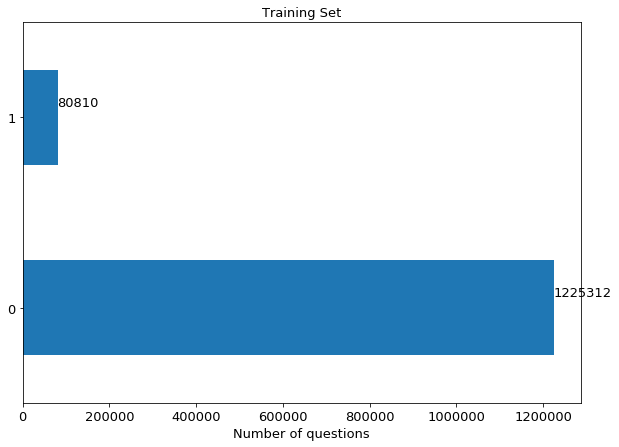

In [8]:
## Understanding Training Data
fig, ax = plt.subplots(nrows=1, ncols=1)
print('###### Value Counts: ######')
target_count = train_data['target'].value_counts()
print(target_count)
visualize_bar(target_count, 'Training Set', 'Number of questions', 'barh', ax)

## Step 2: Undersampling
 From the barchart above, we can clearly detect imbalanced data, the ratio between Class 0 : Class 1 is 15:1, this imposes a problem because it can potentially overfit our data, and the model will always favor class 0 (sincere question).
 
To mitigate the issue, there are a number of techniques that can be used to prevent the overfitting problem, one of the techniques we're going to try in this solution is to undersample our data since our dataset is large. We will use a small proportion of class 0, and change the ratio to approximately 1:1

In [9]:
X = train_data['question_text']
y = train_data['target']
train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=42)

Ratio of Class 1 to Class 0 in Training and Testing sets


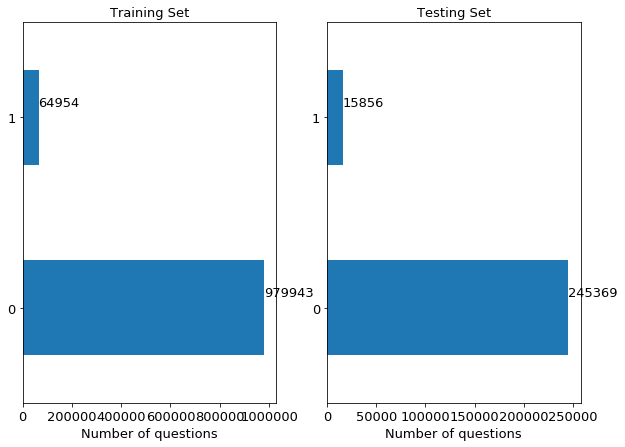

In [10]:
print("Ratio of Class 1 to Class 0 in Training and Testing sets")
fig, axes = plt.subplots(nrows=1, ncols=2)
visualize_bar(train_y.value_counts(), 'Training Set', 'Number of questions', 'barh', axes[0])
visualize_bar(test_y.value_counts(), 'Testing Set', 'Number of questions', 'barh', axes[1])

In [11]:
data_train = pd.concat([train_x, train_y], axis=1)
data_test = pd.concat([test_x, test_y], axis=1)

**** Training Set Sampling ****
Ratio of class 0 to class 1 is 1:1
Training sample shape:  (169443, 2)
Training samples targets count: 
0    104489
1    64954 
Name: target, dtype: int64
**** Test Set Sampling ****
Ratio is 1:1
Testing sample shape:  (41978, 2)
Testing samples targets count: 
0    26122
1    15856
Name: target, dtype: int64


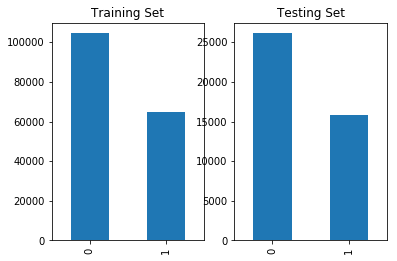

In [112]:
train_sample = undersample(0, 1, data_train, 0.1)
test_sample = undersample(0, 1, data_test, 0.1)

print("**** Training Set Sampling ****")
train_count = train_sample['target'].value_counts()
train_ratio = train_count[0] // train_count[1]
print('Ratio of class 0 to class 1 is {}:1'.format(train_ratio))
print('Training sample shape: ', train_sample.shape)
print('Training samples targets count: ')
print(train_count)


print("**** Test Set Sampling ****")
test_count = test_sample['target'].value_counts()
test_ratio = test_count[0] // test_count[1]
print('Ratio is {}:1'.format(test_ratio))
print('Testing sample shape: ', test_sample.shape)
print('Testing samples targets count: ')
print(test_count)

fig, axes = plt.subplots(nrows=1, ncols=2)
train_count.plot.bar(ax=axes[0], title='Training Set')
test_count.plot.bar(ax=axes[1], title='Testing Set')

In [113]:
# Assign features and labels as X and Y to be later used in the training set
train_sample_x = train_sample['question_text']
train_sample_y = train_sample['target']

test_sample_x = test_sample['question_text']
test_sample_y = test_sample['target']

## Step 3: Feature Engineering

In this section, we will perform some feature engineering to adjust the dataset and reduce its vocabulary. Steps will include:

- Lower casing the dataset
- Removing punctuation
- Removing Stopwords
<!-- - Lemmatization and Stemming -->

In [114]:
porter = PorterStemmer()
def feature_pipeline(sentence):
    sentence = sentence.lower()
    sentence = sentence.strip()
    # Remove Punctuation and numbers
    sentence = re.sub(r"[^a-zA-Z]+", ' ', sentence)
    # Word Punkt Tokenizer
    tokenized_sentence = nltk_wpt.tokenize(sentence)
    # Stem each tokenized word
    sentence = stem_sentence(tokenized_sentence)
    sentence = ' '.join([token for token in sentence if token not in nltk_stopwords])
    return sentence

def stem_sentence(tokenized_sentence):
    stem_sentence = []
    for word in tokenized_sentence:
        stem_sentence.append(porter.stem(word))
    return stem_sentence

In [115]:
formatted_train_sample_x = train_sample_x.apply(feature_pipeline)

## Step 4: Input Vectorization Techniques

### 4.1 Input Vectorization with Word Embeddings


In [116]:
MAX_SEQUENCE_LENGTH = 161 # The longest token in both test and train tests
word_index, padded_train = tokenize_and_pad(formatted_train_sample_x, MAX_SEQUENCE_LENGTH,  True)
padded_test = tokenize_and_pad(test_sample_x, MAX_SEQUENCE_LENGTH)

In [117]:
print('Found %s unique tokens in training set' % len(word_index))
print('Shape of training tensor:', padded_train.shape)
print('Shape of test tensor:', padded_test.shape)

Found 44159 unique tokens in training set
Shape of training tensor: (169443, 161)
Shape of test tensor: (41978, 161)


In [118]:
DIMENSION = 100
embeddings_index = {}
f = open(os.path.join(PATH, f'glove.6B.{DIMENSION}d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [119]:
embedding_matrix = np.zeros((len(word_index) + 1, DIMENSION))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

### 4.2 Oversampling undersampled dataset
Imblearn is a library that provides implementation for SMOTE to oversample our input data to mitigate for the imbalanced training set. The goal here is to bridge the gap between the two binary classes. The reason we perform this step on the previously undersampled dataset is because our original dataset is huge and if we perform oversampling on the original dataset it will likely malfunction in our model, and will not yield the correct results, also it is going to take a lot of time to converge, so the performance of the model is going to be slow and might not yield the correct result.

In [62]:
# from imblearn.over_sampling import SMOTE

# smote = SMOTE('minority')
# X_smote, y_smote = smote.fit_sample(padded_train, train_sample_y)

In [63]:
# print(padded_train.shape, train_sample_y.shape)
# print(X_smote.shape, y_smote.shape)
# unique, counts = np.unique(y_smote, return_counts=True)
# print(unique, counts)

(482912, 161) (482912,)
(835916, 161) (835916,)
[0 1] [417958 417958]


## Step 5: Training the Model

### 5.1 Naive Bayes Model
Naive bayes is used as the benchmark model to compare our CNN results to

In [70]:
# ## NAIVE BAYES MODEL USING EMBEDDINGS AND SMOTE INPUT
# from sklearn.naive_bayes import MultinomialNB
# naive_bayes = MultinomialNB()
# naive_bayes.fit(X_smote, y_smote)
# NBpredictionsSMOTE = naive_bayes.predict(padded_test)
# X_smote.shape, y_smote.shape, padded_test.shape

((835916, 161), (835916,), (120346, 161))

In [120]:
## NAIVE BAYES MODEL USING WORD EMBEDDINGS
from sklearn.naive_bayes import MultinomialNB
naive_bayes = MultinomialNB()
naive_bayes.fit(padded_train, train_sample_y)
NBpredictions = naive_bayes.predict(padded_test)

### 5.1 CNN Model

In this step we experiment with numerious hyperparameters and layers of CNN to improve the overall output model

In [187]:
# Hyperparameters
EPOCHS = 50
VAL_SPLIT = 0.2
MAX_SEQUENCE_LENGTH=161

In [164]:
embedding_layer = Embedding(len(word_index) + 1,
                            DIMENSION,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)

In [194]:
## CNN USING EMBEDDINGS AND SMOTE INPUT
# define model
import keras
from keras import regularizers


optimizer = keras.optimizers.Adam(lr=0.01, beta_1=0.7, beta_2=0.999, epsilon=1e-8)
model = Sequential()
model.add(embedding_layer)
model.add(Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

# compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# summarize the model
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 161, 100)          4416000   
_________________________________________________________________
dense_85 (Dense)             (None, 161, 256)          25856     
_________________________________________________________________
dropout_60 (Dropout)         (None, 161, 256)          0         
_________________________________________________________________
flatten_34 (Flatten)         (None, 41216)             0         
_________________________________________________________________
dense_86 (Dense)             (None, 1)                 41217     
Total params: 4,483,073
Trainable params: 67,073
Non-trainable params: 4,416,000
_________________________________________________________________
None


In [195]:
from keras.utils.np_utils import to_categorical
y_binary = to_categorical(train_sample_y)

# fit the model
history = model.fit(padded_train,
          train_sample_y,
          epochs=EPOCHS,
          verbose=1,
          validation_split=0.2,
#           class_weight={0:1, 1:2}
         )

Train on 135554 samples, validate on 33889 samples
Epoch 1/50
135554/135554 [==============================] - 46s 336us/step - loss: 0.3607 - acc: 0.8611 - val_loss: 0.6991 - val_acc: 0.6487
Epoch 2/50
135554/135554 [==============================] - 46s 339us/step - loss: 0.3361 - acc: 0.8701 - val_loss: 0.8349 - val_acc: 0.5817
Epoch 3/50
135554/135554 [==============================] - 46s 343us/step - loss: 0.3330 - acc: 0.8721 - val_loss: 0.8371 - val_acc: 0.5949
Epoch 4/50
135554/135554 [==============================] - 46s 338us/step - loss: 0.3293 - acc: 0.8733 - val_loss: 0.7746 - val_acc: 0.6111
Epoch 5/50
135554/135554 [==============================] - 46s 337us/step - loss: 0.3278 - acc: 0.8746 - val_loss: 0.6888 - val_acc: 0.6569
Epoch 6/50
135554/135554 [==============================] - 48s 352us/step - loss: 0.3276 - acc: 0.8742 - val_loss: 1.0070 - val_acc: 0.4856
Epoch 7/50
135554/135554 [==============================] - 46s 339us/step - loss: 0.3272 - acc: 0.8739

### CNN Prediction
Predict Classes for the sample test data

In [196]:
CNNpredictionsClass = model.predict_classes(padded_test, verbose=0)
CNNpredictions = model.predict(padded_test, verbose=0)

## Step 6: Metrics and Score

In this step we perform a comparison between the benchmark model and the CNN model using the F1-Score to measure their performance.

In [197]:
from sklearn import metrics
def get_metrics(true_labels, predicted_labels, feature):
    print(feature)
    print('Accuracy:', metrics.accuracy_score(true_labels, predicted_labels))
    print('Precision:', metrics.precision_score(true_labels, predicted_labels))
    print('Recall:', metrics.recall_score(true_labels, predicted_labels))
    print('F1 Score:', metrics.f1_score(true_labels, predicted_labels))
    print('\n')

### 6.1 Naive Bayes Model Accuracy

In [141]:
get_metrics(test_sample_y, NBpredictions, 'Predictions for NB')

Predictions for NB
Accuracy: 0.607937491067
Precision: 0.485467361916
Recall: 0.634144803229
F1 Score: 0.549934368847




### 6.2 CNN Model Accuracy

In [198]:
get_metrics(test_sample_y, CNNpredictionsClass, 'Predictions for CNN')

Predictions for CNN
Accuracy: 0.466434799181
Precision: 0.367302231237
Recall: 0.571014127144
F1 Score: 0.44704488224




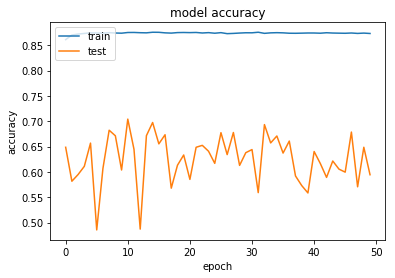

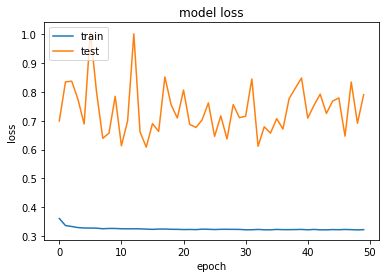

In [199]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()